本人是Python&PyTorch新手，为了完成毕业设计而选择学习PyTorch。
在学习过程中，将自己不懂的代码全部进行了注释。
学完了「60分钟入门深度学习工具-PyTorch」这个教程后，觉得自己的注释也许会帮助与我水平差不多的初学者们节省不少时间，所以就把注释详尽的「3.神经网络」、「4.训练一个分类器」分享出来。
注释很多但也显得很乱，建议和原版教程一起看，原版教程看不懂就看一下我的这个版本。

（我其实学了两遍，因为第一遍跟着打了一遍代码，模模糊糊，不知道为什么要这么做，第二遍把几乎每一行代码都进行注释，才感觉自己真正学到了东西）

In [1]:
import torch  # 包 torch 包含了多维张量的数据结构以及基于其上的多种数学操作。另外，它也提供了多种工具，其中一些可以更有效地对张量和任意类型进行序列化。
import torchvision  # torchvision包 包含了目前流行的数据集，模型结构和常用的图片转换工具。该包主要由3个子包组成，分别是：torchvision.datasets、torchvision.models、torchvision.transforms
import torchvision.transforms as transforms  # 常用的图像转换工具包。
# Matplotlib 可能是 Python 2D-绘图领域使用最广泛的套件。它能让使用者很轻松地将数据图形化，并且提供多样化的输出格式。这里将会探索 matplotlib 的常见用法。
import matplotlib.pyplot as plt
# NumPy(Numerical Python) 是 Python 语言的一个扩展程序库，支持大量的维度数组与矩阵运算，此外也针对数组运算提供大量的数学函数库。
import numpy as np
import torch.nn as nn  # 引入神经网络模块
import torch.nn.functional as F  # 引入神经网络函数模块
# torch.optim是一个实现了各种优化算法的库。大部分常用的方法得到支持，并且接口具备足够的通用性，使得未来能够集成更加复杂的方法。
import torch.optim as optim

In [2]:
transform = transforms.Compose(  # 通常使用transforms.Compose将transforms组合在一起
    [
        # 将 PIL(Python Imaging Library，Python平台图像处理标准库) 或者 numpy.ndarray(NumPy的 N 维数组对象 ndarray) 转换成 tensor 形式
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # 但是为什么这里填的是 (0.5,0.5,0.5),(0.5,0.5,0.5) 我还不明白。为什么用多个transform我也不明白。
    ]
)
""" 
torchvision.transforms.Normalize(mean, std, inplace=False)
使用均值、标准差，对张量图像归一化。
调用该函数前，应先将数据处理为tensor.
 """
trainset = torchvision.datasets.CIFAR10(
    root="./data/",  # 设置数据集所在目录
    train=True,  # True = 加载训练集, False = 加载测试集
    download=True,  # True = 从互联上下载数据，并将其放在root目录下。如果数据集已经下载，什么都不干。
    transform=transform  # 表示使用transform所定义的处理方法对数据进行预处理，如果设置为 None，则表示不进行预处理。
    #dataset.CIFAR10(root, train=True, transform=None, target_transform=None, download=False)
)
'''
torchvision.datasets中包含了以下数据集
    MNIST
    COCO（用于图像标注和目标检测）(Captioning and Detection)
    LSUN Classification
    ImageFolder
    Imagenet-12
    CIFAR10 and CIFAR100
    STL10
所有数据集都具有几乎相似的API。
它们都有两个共同的参数：transform和target_transform分别转换输入和目标。
'''
trainloader = torch.utils.data.DataLoader(
    trainset,  # 要加载的数据集
    batch_size=4,  # 每个batch加载多少个样本，默认为1；将训练集的50000张图片划分成12500份，每份4张图
    shuffle=True,  # 设置为True时会在每个epoch重新打乱数据
    num_workers=2  # 用2个子进程加载数据。0表示数据将在主进程中加载(默认: 0)
)
"""
    torch.utils.data表示Dataset的抽象类。
    torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, num_workers=0, collate_fn=<function default_collate>, pin_memory=False, drop_last=False)
"""
testset = torchvision.datasets.CIFAR10(
    root="./data/",  # 设置数据集所在目录
    train=False,  # True = 加载训练集, False = 加载测试集
    download=True,  # True = 从互联上下载数据，并将其放在root目录下。如果数据集已经下载，什么都不干。
    transform=transform  # 表示使用transform所定义的处理方法对数据进行预处理，如果设置为 None，则表示不进行预处理。
)
testloader = torch.utils.data.DataLoader(
    testset,  # 要加载的数据集
    batch_size=4,  # 每个batch加载多少个样本，默认为1；将训练集的50000张图片划分成12500份，每份4张图
    shuffle=False,  # 设置为True时会在每个epoch重新打乱数据
    num_workers=2  # 用2个子进程加载数据。0表示数据将在主进程中加载(默认: 0)
)
classes = (
    # 每个分类的标签
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
)

Files already downloaded and verified
Files already downloaded and verified


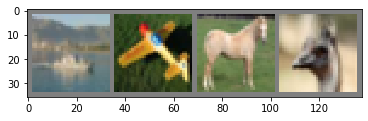

ship plane horse  bird


In [4]:
def imshow(img):
    # 用于显示图片的函数
    img = img / 2 + 0.5  # 这一步看不懂，教程说是unnormalize
    npimg = img.numpy()  # 将tensor对象转换为numpy对象
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    """
    numpy.transpose(a, axes=None)
    输入数组a，
    默认情况下调换行列，axes不为None时，按照axes指定的值排列维度。
        >>> x = np.ones((1, 2, 3))
        >>> np.transpose(x, (1, 0, 2)).shape
        (2, 1, 3)
    上述操作将第0、1维置换，第2维未变。
    """
    plt.show()  # matplotlib.pyplot.show（* args，** kw ）     用于显示图像


dataiter = iter(trainloader)  # iter() 函数用来生成迭代器。
"""
iter(object[, sentinel])
    返回一个 iterator 对象。根据是否存在第二个实参，第一个实参的解释是非常不同的。如果没有第二个实参，object 必须是支持迭代协议（有 __iter__() 方法）的集合对象，或必须支持序列协议（有 __getitem__() 方法，且数字参数从 0 开始）。如果它不支持这些协议，会触发 TypeError。如果有第二个实参 sentinel，那么 object 必须是可调用的对象。这种情况下生成的迭代器，每次迭代调用它的 __next__() 方法时都会不带实参地调用 object；如果返回的结果是 sentinel 则触发 StopIteration，否则返回调用结果。
iterator -- 迭代器
    用来表示一连串数据流的对象。重复调用迭代器的 __next__() 方法（或将其传给内置函数 next()）将逐个返回流中的项。当没有数据可用时则将引发 StopIteration 异常。到这时迭代器对象中的数据项已耗尽，继续调用其 __next__() 方法只会再次引发 StopIteration 异常。迭代器必须具有 __iter__() 方法用来返回该迭代器对象自身，因此迭代器必定也是可迭代对象，可被用于其他可迭代对象适用的大部分场合。
"""

images, labels = dataiter.next()
"""
通过调用 iterator 的 __next__() 方法获取下一个元素。如果迭代器耗尽，则返回给定的 default，如果没有默认值则触发 StopIteration。
"""

imshow(torchvision.utils.make_grid(images))
"""
调用自定义的imshow()函数；
torchvision.utils.make_grid(tensor, nrow=8, padding=2, normalize=False, range=None, scale_each=False, pad_value=0 → 制作图像网格
"""

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [3]:
class Net(nn.Module):  # 继承nn模块的Module类（所有网络的基类）
    """从之前的神经网络教程中复制的代码，将单通道改成了3通道,使用nn.MaxPool2d(2,2)池化，（不过难道之前没有池化吗？哦，之前的池化代码放的位置不一样）"""

    def __init__(self):
        super(Net, self).__init__()  # 将构造方法委托给Net的父类Module
        self.conv1 = nn.Conv2d(3, 6, 5)  # 第一层二维卷积层，输入3个信号通道，输出6个信号通道，使用5*5的卷积核
        self.pool = nn.MaxPool2d(2, 2)
        # 第二层二维卷积层，输入6个信号通道，输出16个信号通道，使用5*5的卷积核
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 第一层全连接层，对输入数据线进行线性变换，输入16*5*5个样本，输出120个样本
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)  # 第二层全连接层，对输入数据线进行线性变换，输入120个样本，输出84个样本
        self.fc3 = nn.Linear(84, 10)  # 第三层全连接层，对输入数据线进行线性变换，输入84个样本，输出10个样本

    def forward(self, x):  # 定义每次执行的计算步骤，所有子类都要重写这个函数。
        x = self.pool(F.relu(self.conv1(x)))
        # 将数据集传入，生成第一层卷积层。
        # 使用非线性激活函数relu()处理输入，得出输出（不同分类的概率）
        # 对输入平面conv1进行最大池化，池化窗口大小为2*2
        x = self.pool(F.relu(self.conv2(x)))
        # 将数据集传入，生成第二层卷积层。
        # 使用非线性激活函数relu()处理输入，得出输出（不同分类的概率）
        # 对输入平面conv2进行最大池化，池化窗口大小为2*2（正方形的池化窗口可以直接用单个数字表示）
        x = x.view(-1, 16*5*5)
        # 将第二次池化后得出的数据集展开成列向量，方便后续的线性运算。
        x = F.relu(self.fc1(x))
        # 将数据集传输fc1层进行线性运算
        # 将线性运算后的结果使用非线性激活函数relu()处理 ，输出
        x = F.relu(self.fc2(x))
        # 将数据集传输fc2层进行线性运算
        # 将线性运算后的结果使用非线性激活函数relu()处理 ，输出
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
# torch.nn.CrossEntropyLoss(weight=None, size_average=True)
criterion = nn.CrossEntropyLoss()
"""
此标准将LogSoftMax和NLLLoss集成到一个类中。
当训练一个多类分类器的时候，这个方法是十分有用的。
"""
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)
实现随机梯度下降算法（momentum可选）。
    params (iterable) – 待优化参数的iterable或者是定义了参数组的dict
    lr (float) – 学习率
    momentum (float, 可选) – 动量因子（默认：0）
    weight_decay (float, 可选) – 权重衰减（L2惩罚）（默认：0）
    dampening (float, 可选) – 动量的抑制因子（默认：0）
    nesterov (bool, 可选) – 使用Nesterov动量（默认：False）

训练网络时，通常先对网络的初始权值按照某种分布进行初始化，如：高斯分布。初始化权值操作对最终网络的性能影响比较大，合适的网络初始权值能够使得损失函数在训练过程中的收敛速度更快，从而获得更好的优化结果。但是按照某类分布随机初始化网络权值时，存在一些不确定因素，并不能保证每一次初始化操作都能使得网络的初始权值处在一个合适的状态。不恰当的初始权值可能使得网络的损失函数在训练过程中陷入局部最小值，达不到全局最优的状态。因此，如何消除这种不确定性，是训练深度网络是必须解决的一个问题。
momentum 动量能够在一定程度上解决这个问题。momentum 动量是依据物理学的势能与动能之间能量转换原理提出来的。
当 momentum 动量越大时，其转换为势能的能量也就越大，就越有可能摆脱局部凹域的束缚，进入全局凹域。momentum 动量主要用在权重更新的时候。

一般，神经网络在更新权值时，采用如下公式:
    w = w - learning_rate * dw
引入momentum后，采用如下公式：
    v = mu * v - learning_rate * dw
    w = w + v
其中，v初始化为0，mu是设定的一个超变量，最常见的设定值是0.9。可以这样理解上式：如果上次的momentum(v)与这次的负梯度方向是相同的，那这次下降的幅度就会加大，从而加速收敛。

由于动量积攒了历史的梯度，如点P前一刻的梯度与当前的梯度方向几乎相反。因此原本在P点原本要大幅徘徊的梯度，主要受到前一时刻的影响，而导致在当前时刻的梯度幅度减小。
直观上讲就是，要是当前时刻的梯度与历史时刻梯度方向相似，这种趋势在当前时刻则会加强；要是不同，则当前时刻的梯度方向减弱。

一般将参数设为0.5,0.9，或者0.99，分别表示最大速度2倍，10倍，100倍于SGD的算法。

In [6]:
for epoch in range(2):
    """
    当一个完整的数据集通过了神经网络一次并且返回了一次，这个过程称为一个 epoch。
    """
    running_loss = 0.0  # 创建并初始化损失
    # enumerate(iterable, start=0) 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中。
    for i, data in enumerate(trainloader, 0):
        """
        此处的 i 应该就是返回的索引值了，放个 i 在这是为了把这个不需要的索引值弄走。
        data则是返回的训练集数据（包含图像数据、标签）
        """
        inputs, labels = data  # 将data数据分为图像输入、标签
        optimizer.zero_grad()  # 将梯度清空
        outputs = net(inputs)  # 将数据集放入神经网络中获得输出
        loss = criterion(outputs, labels)  # 将输出与标签放入损失函数，计算损失
        loss.backward()  # 将损失用于反向传播
        optimizer.step()  # 进行单次优化 (参数更新)

        running_loss += loss.item()  # 将损失累加，用于之后打印损失值
        if (i % 2000) == 1999:  # 每2000次迭代，打印一次
            print("[%d, %5d] loss: %.3f" % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print("Finished Training. ")

[1,  2000] loss: 2.253
[1,  4000] loss: 1.924
[1,  6000] loss: 1.713
[1,  8000] loss: 1.613
[1, 10000] loss: 1.550
[1, 12000] loss: 1.507
[2,  2000] loss: 1.428
[2,  4000] loss: 1.388
[2,  6000] loss: 1.376
[2,  8000] loss: 1.343
[2, 10000] loss: 1.329
[2, 12000] loss: 1.312
Finished Training. 


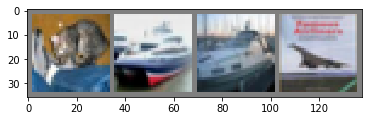

GroundTruch:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print("GroundTruch: ", " ".join("%5s" % classes[labels[j]] for j in range(4)))

In [8]:
outputs = net(images)

In [9]:
print(outputs)  # 输出的是当前图像属于10个标签中每个的概率

tensor([[-0.9159, -2.0933,  0.4017,  2.4819,  0.4459,  2.3379, -0.2480, -0.0752,
          0.1993, -2.2941],
        [ 5.1318,  6.0385, -0.8503, -2.9958, -4.1302, -3.4819, -4.4751, -3.5937,
          5.5780,  5.5318],
        [ 3.0497,  1.4115, -0.0464, -1.0653, -1.7521, -1.8088, -2.7524, -1.7013,
          3.5105,  1.9746],
        [ 4.0660,  1.6297, -0.0208, -1.6957, -1.9072, -2.5759, -3.3095, -1.8954,
          4.6477,  2.2221]], grad_fn=<AddmmBackward>)


In [10]:
_, predicted = torch.max(outputs, 1)
""" 
torch.max(input, other, out=None) → Tensor
返回输入张量给定维度上每行的最大值，并同时返回每个最大值的位置索引。 即，outi=max(inputi,otheri)
输出形状中，将dim维设定为1，其它与输入形状保持一致。
此时的torch.max(outputs)的尺寸为：torch.Size([4, 10])，共计两个维度（0，1）。
维度0为每列的最大值，不是我们需要的，维度1为每行的最大值，是我们需要的。


_ 是返回的每个维度的最大值（在这里没用，单个独立下划线是用作一个名字，来表示某个变量是临时的或无关紧要的）
predicted 是每个最大值的索引。
"""

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
# 然后按照索引打印classes中的字符串

Predicted:    cat   car  ship  ship


classes = (
    # 每个分类的标签
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
) 

In [11]:
print(_)

tensor([2.4819, 6.0385, 3.5105, 4.6477], grad_fn=<MaxBackward0>)


In [12]:
print(predicted)

tensor([3, 1, 8, 8])


In [13]:
for j in range(4):
    print(classes[predicted[j]])

cat
car
ship
ship


In [14]:
correct = 0  # 创建并初始化正确数
total = 0  # 创建并初始化总数
with torch.no_grad():
    # 对于不需要反向传播的情景，使用 with torch.no_grad() 可以实现一定速度的提升，并节省一半的显存，因为其不需要保存梯度。
    for data in testloader:
        images, labels = data  # 依次提取每个图像和其标签
        outputs = net(images)  # 将当前图片输入网络，获取预测
        _, predicted = torch.max(outputs.data, 1)  # 从预测值列表中获取维度1最大值的索引
        # 之所以不直接+1，应该是因为labels.size()==4，即这个数据集是每4个一组被读取的。
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        """
        #.item()，从只有一个值的Tensor中获取Python Number
        因为
        (predicted==labels)==tensor([ True,  True, False,  True])，是个tensor对象
        (predicted==labels).sum()==tensor(3)，是个tensor对象
        (predicted==labels).sum().item())==3，是个数值对象
        """

print('Accuracy of the network on the 10000 test images: %d %%' %
      (100 * correct / total))  # 打印将测试集的10000个数据输入后的正确率

Accuracy of the network on the 10000 test images: 53 %


In [16]:
print(labels.size())
print(labels.size(0))

torch.Size([4])
4


In [19]:
print(predicted == labels)
print((predicted == labels).sum())
print((predicted == labels).sum().item())

tensor([ True,  True, False,  True])
tensor(3)
3


In [20]:
class_correct = list(0. for i in range(10))  # 创建并初始化正确预测数量列表
class_total = list(0. for i in range(10))  # 创建并初始化总数量列表
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()  # 好像没什么变化
        """
        torch.squeeze(input, dim=None, out=None)
        将输入张量形状中的1 去除并返回。 
        如果输入是形如(A×1×B×1×C×1×D)，那么输出形状就为： (A×B×C×D)
        当给定dim时，那么挤压操作只在给定维度上。例如，输入形状为: (A×1×B), squeeze(input, 0) 将会保持张量不变，只有用 squeeze(input, 1)，形状会变成 (A×B)。
        """
        for i in range(4):
            label = labels[i]  # 获取当前这组图像的标签对应索引
            # 在正确预测数量列表的索引处，增加1或0（True或False）
            class_correct[label] += c[i].item()
            class_total[label] += 1  # 预测总数+1

for i in range(10):
    print('Accuracy of %5s : %2d %%' %
          (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 57 %
Accuracy of  bird : 22 %
Accuracy of   cat : 24 %
Accuracy of  deer : 38 %
Accuracy of   dog : 55 %
Accuracy of  frog : 67 %
Accuracy of horse : 70 %
Accuracy of  ship : 76 %
Accuracy of truck : 69 %


In [21]:
print((predicted == labels))
print((predicted == labels).squeeze())

tensor([ True,  True, False,  True])
tensor([ True,  True, False,  True])


In [23]:
for i in range(4):
    print(c[i])
    print(c[i].item())

tensor(True)
True
tensor(True)
True
tensor(False)
False
tensor(True)
True


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")  # 假设我们有一台CUDA的机器，这个操作将显示CUDA设备。
print(device)

cuda:0


In [26]:
net.to(device)  # 假设我们有一台CUDA的机器，然后这些方法将递归遍历所有模块并将其参数和缓冲区转换为CUDA张量

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
inputs, labels = inputs.to(device), labels.to(
    device)  # 也必须在每一步中把你的输入和目标值转换到GPU上